In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
from ipywidgets import interactive
import ipywidgets as widgets
#from QSM_and_qBOLD_functions import f_qBOLD, f_QSM
from scipy.optimize import curve_fit

In [2]:
def f_hyper(x):
    '''
    Write hypergeometric function as taylor order 10 for beginning and as x-1 for larger numbers
    Exakt equation: hypergeom(-0.5,[0.75,1.25],-9/16*x.^2)-1
    (Intersection>x)*taylor + (x>=Intersection)*(x-1)
    taylor = - (81*x^8)/10890880 + (27*x^6)/80080 - (3*x^4)/280 + (3*x^2)/10
    Intersection at approx x = 3.72395
    
    '''
    Intersection = 3.72395
    a = (Intersection>x)*( -81./10890880*pow(x,8) +27./80080*pow(x,6) -3./280*pow(x,4) +0.3*pow(x,2) )
    b = (x>=Intersection)*(x-1)
    return a + b

Hypergeometric Function is approx 0.3*x^2 for x <1.5 and x-1 for x>1.5

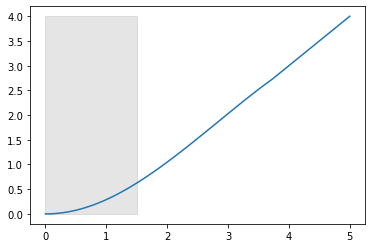

In [3]:
plt.figure()
x=np.linspace(0,5,num=100)
plt.plot(x,f_hyper(x))
plt.fill_betweenx(y=[0,4],x1=0,x2=1.5,alpha=0.2,color='grey')
plt.show()

In [4]:
def f_dw(Y,chi_nb):
    Hct = 0.357             
    psi_Hb = Hct*0.34/1.335 # Blood Hb volume fraction
    chi_oHb = -0.813        # Susceptibility of oxyhemoglobin in ppm
    chi_p = -0.0377         # Susceptibility of plasma in ppm
    chi_ba = psi_Hb*chi_oHb + (1-psi_Hb)*chi_p # Susceptibility of fully oxygenated blood in ppm
    delta_chi0 = 4*np.pi*0.273 #in ppm
    #CF = gamma *B0
    gamma = 267.513 #10^6 rad/s/T
    #gamma = 42.577 #gamma divided by 2pi in MHz/T
    B0 = 3 #T
    dw = 1./3 * gamma * B0* (Hct * delta_chi0 * (1-Y) + chi_ba - chi_nb )
    return dw

In [5]:
def f_qBOLD(t, S0, R2, Y, nu, chi_nb, TE = 40./1000 ):
    output=np.zeros_like(t)
    for i in range(len(t)):
        if(t[i]<TE/2): #FID
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) *     t[i] ) )
        elif(t[i]>TE): #SE fall  
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) * (t[i]-TE) ) )
        else:          #SE rise
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) * (TE-t[i]) ) )
    return output


In [6]:
def f_QSM(Y, nu, chi_nb ):
    Hct = 0.357
    SaO2 = 0.98
    alpha = 0.77;              # Ratio of deoxygenated and total blood volume
    delta_chi_Hb = 12.522;     # Susceptibility difference between dHb and Hb in ppm
    psi_Hb = Hct*0.34/1.335    # Blood Hb volume fraction
    chi_oHb = -0.813           # Susceptibility of oxyhemoglobin in ppm
    chi_p = -0.0377            # Susceptibility of plasma in ppm
    chi_ba = psi_Hb*chi_oHb + (1-psi_Hb)*chi_p # Susceptibility of fully oxygenated blood in ppm

    blood = (chi_ba/alpha +psi_Hb*delta_chi_Hb * ((1-(1-alpha)*SaO2)/alpha - Y) )*nu
    non_blood = (1 - nu/alpha) * chi_nb
    return blood + non_blood

White Matter: R2 = 12 +- 6 Hz, Y = 60 +- 30 %, nu = 4 +- 2%, chi_nb = -0.04 +- 0.04 ppm <br />
Grey  Matter: R2 = 17 +- 4 Hz, Y = 60 +- 30 %, nu = 4 +- 2%, chi_nb = -0.05 +- 0.04 ppm

In [7]:
S0_slider = widgets.FloatSlider( min=   0, max=   2, value=  1, step=  .1, description='S0', continuous_update=False)
R2_slider = widgets.IntSlider(   min=   6, max=  21, value= 12,            description='R2 [Hz]', continuous_update=False)
Y_slider  = widgets.FloatSlider( min=   0, max= .98, value= .6, step= .01, description='Y', continuous_update=False)
nu_slider = widgets.FloatSlider( min= .02, max= .06, value= .04, step= .01, description='nu', continuous_update=False)
chi_nb_slider=widgets.FloatSlider(min=-.1, max=   0.1, value=-.04, step= .01, description='chi_nb [ppm]', continuous_update=False)
TE_slider = widgets.IntSlider(   min=  5,  max= 100, value= 40,            description='TE [ms]', continuous_update=False)
ui = widgets.HBox([S0_slider, R2_slider, Y_slider, nu_slider, chi_nb_slider, TE_slider])

In [8]:
def plot_QSM_qBOLD_GRE(S0, R2, Y, nu, chi_nb):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5),gridspec_kw={'width_ratios': [4, 1]})
    ax=axes.ravel()
    
    t = np.linspace(0, 50, num=100)/1000
    ax[0].plot(t*1000,f_qBOLD(t,S0, R2, Y, nu, chi_nb, 100))
    ax[0].plot(t*1000,S0*np.exp(-R2*t))
    
    t_GRE = np.linspace(4.5,4.5+8*5.5,8)/1000
    ax[0].plot(t_GRE*1000,f_qBOLD(t_GRE,S0, R2, Y, nu, chi_nb, 100),'or')
    
    ax[0].title.set_text('qBOLD')
    ax[0].set_xlabel('t [ms]')
    ax[0].set_ylim(0, 1.1)
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    ax[0].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    
    ax[1].plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    ax[1].title.set_text('QSM')
    ax[1].set_ylim(-0.1,0.05)
    plt.show()

In [9]:
interactive_plot = interactive(plot_QSM_qBOLD_GRE,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…

In [10]:
def plot_QSM_qBOLD_GESSE(S0, R2, Y, nu, chi_nb):
    TE = (29+10*2)/1000
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5),gridspec_kw={'width_ratios': [4, 1]})
    ax=axes.ravel()
    
    t = np.linspace(0, 100, num=100)/1000
    ax[0].plot(t*1000,f_qBOLD(t,S0, R2, Y, nu, chi_nb, TE))
    ax[0].plot(t*1000,S0*np.exp(-R2*t))
    
    t_GESSE = np.linspace(29,29+32*2,32)/1000
    ax[0].plot(t_GESSE*1000,f_qBOLD(t_GESSE,S0, R2, Y, nu, chi_nb, TE),'.r')
    ax[0].title.set_text('qBOLD, TE = 49ms')
    ax[0].set_xlabel('t [ms]')
    ax[0].set_ylim(0, 1.1)
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    ax[0].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    ax[0].fill_betweenx(y=[0,1.1],x1=TE*1000-t_trans,x2=TE*1000+t_trans,alpha=0.2,color='grey')
    
    ax[1].plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    ax[1].title.set_text('QSM')
    ax[1].set_ylim(-0.1,0.05)
    plt.show()

In [11]:
interactive_plot = interactive(plot_QSM_qBOLD_GESSE,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…

In [ ]:
def plot_QSM_qBOLD(S0, R2, Y, nu, chi_nb, TE):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,10),gridspec_kw={'width_ratios': [4, 1]})
    gs = axes[0, 1].get_gridspec()
    
    t = np.linspace(0, 70, num=100)/1000
    qBOLD_values = f_qBOLD(t,S0, R2, Y, nu, chi_nb, TE/1000)
    Exp_values = S0*np.exp(-R2*t)
    
    t_sampled = np.linspace(3,3+16*3,16)/1000
    qBOLD_sampled = f_qBOLD(t_sampled,S0, R2, Y, nu, chi_nb, TE/1000)
    
    axes[0,0].plot(t*1000,qBOLD_values)
    axes[0,0].plot(t*1000,Exp_values)
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled,'.r')
    axes[0,0].title.set_text('qBOLD')
    axes[0,0].set_ylim(0, 1.1)
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    #axes[0,0].vlines([t_trans,TE-t_trans,TE+t_trans],0,1.1,'k')
    axes[0,0].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    axes[0,0].fill_betweenx(y=[0,1.1],x1=TE-t_trans,x2=TE+t_trans,alpha=0.2,color='grey')
    
    axes[1,0].plot(t*1000,qBOLD_values-Exp_values)
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled-S0*np.exp(-R2*t_sampled),'.r')
    axes[1,0].set_xlabel('t [ms]')
    axes[1,0].set_ylim(-0.15,0.01)
    axes[1,0].fill_betweenx(y=[-0.15,0.01],x1=0,x2=t_trans,alpha=0.2,color='grey')
    axes[1,0].fill_betweenx(y=[-0.15,0.01],x1=TE-t_trans,x2=TE+t_trans,alpha=0.2,color='grey')
    
    for ax in axes[:,1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:,1])
    axbig.plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    axbig.title.set_text('QSM')
    axbig.set_ylim(-0.1,0.05)
    
    
    plt.show()

In [ ]:
interactive_plot = interactive(plot_QSM_qBOLD,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider, TE=TE_slider)
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

In [27]:
def plot_Smoker(S0, R2, Y, nu, chi_nb):
    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(10,12))
    
    t = np.linspace(0, 160, num=100)/1000
    t_GRE = np.linspace(4.5,4.5+(12-1)*5.5,12)/1000
    t_GESSE = np.linspace(13.1,13.1+(12-1)*13.1,12)/1000
    
    qBOLD_values = f_qBOLD(t,S0 *0.9, R2, Y, nu, chi_nb, 1000)
    GESSE_values = S0*np.exp(-R2*t)
    
    qBOLD_sampled = f_qBOLD(t_GRE,S0*0.9, R2, Y, nu, chi_nb, 1000)
    GESSE_sampled = S0*np.exp(-R2*t_GESSE)
    
    axes[0].plot(t*1000,qBOLD_values,'r')
    axes[0].plot(t*1000,GESSE_values,'b')
    axes[0].plot(t_GRE*1000,qBOLD_sampled,'or')
    axes[0].plot(t_GESSE*1000,GESSE_sampled,'ob')
    
    axes[0].set_ylim(0, 1.1)
    axes[0].set_xlabel('t [ms]')
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    axes[0].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    
    axes[1].plot(t*1000,qBOLD_values/GESSE_values,'r')
    axes[1].plot(t_GRE*1000,qBOLD_sampled/(S0*np.exp(-R2*t_GRE)),'or')
    #axes[1].plot(t_GESSE*1000,GESSE_sampled,'ob')
    
    #axes[1].set_xlim(0, 70)
    #axes[1].set_ylim(0, 1.1)
    axes[1].set_xlabel('t [ms]')
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    #axes[1].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    
    plt.tight_layout()
    plt.show()

In [28]:
interactive_plot = interactive(plot_Smoker,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider, TE=TE_slider)
output = interactive_plot.children[-1]
output.layout.height = '900px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…

Look at log(f_qBOLD)

In [ ]:
def plot_QSM_qBOLD_log(S0, R2, Y, nu, chi_nb, TE):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,10),gridspec_kw={'width_ratios': [4, 1]})
    gs = axes[0, 1].get_gridspec()
    
    t = np.linspace(0, 70, num=100)/1000
    qBOLD_values = f_qBOLD(t,S0, R2, Y, nu, chi_nb, TE/1000)
    Exp_values = S0*np.exp(-R2*t)
    
    t_sampled = np.linspace(3,3+16*3,16)/1000
    qBOLD_sampled = f_qBOLD(t_sampled,S0, R2, Y, nu, chi_nb, TE/1000)
    
    axes[0,0].plot(t*1000,qBOLD_values)
    axes[0,0].plot(t*1000,Exp_values)
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled,'.r')
    axes[0,0].title.set_text('qBOLD')
    #axes[0,0].set_ylim(0, 1.1)
    axes[0,0].set_yscale('log')
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    #axes[0,0].vlines([t_trans,TE-t_trans,TE+t_trans],0,1.1,'k')
    axes[0,0].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    axes[0,0].fill_betweenx(y=[0,1.1],x1=TE-t_trans,x2=TE+t_trans,alpha=0.2,color='grey')
    
    axes[1,0].plot(t*1000,qBOLD_values-Exp_values)
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled-S0*np.exp(-R2*t_sampled),'.r')
    axes[1,0].set_xlabel('t [ms]')
    axes[1,0].set_ylim(-0.15,0.01)
    axes[1,0].fill_betweenx(y=[-0.15,0.01],x1=0,x2=t_trans,alpha=0.2,color='grey')
    axes[1,0].fill_betweenx(y=[-0.15,0.01],x1=TE-t_trans,x2=TE+t_trans,alpha=0.2,color='grey')
    
    for ax in axes[:,1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:,1])
    axbig.plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    axbig.title.set_text('QSM')
    axbig.set_ylim(-0.1,0.05)
    
    
    plt.show()

In [ ]:
interactive_plot = interactive(plot_QSM_qBOLD_log,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider, TE=TE_slider)
output = interactive_plot.children[-1]
output.layout.height = '700px'
interactive_plot

Compare Y=0.6,nu=0.04 with Y=0.3, nu=0.02. They look very similar in shape of qBOLD and in QSM, but width of grey areas is different 

In [ ]:
def plot_fit_comparison(R2,chi_nb,TE,t,Y1,Y2,Y3,Y4,nu1,nu2,nu3,nu4,true_value):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,10),gridspec_kw={'width_ratios': [4, 1]})
    gs = axes[0, 1].get_gridspec()

    qBOLD_values1 = f_qBOLD(t=t, S0=1, R2=R2, Y=Y1, nu=nu1, chi_nb=chi_nb, TE=TE)
    qBOLD_values2 = f_qBOLD(t=t, S0=1, R2=R2, Y=Y2, nu=nu2, chi_nb=chi_nb, TE=TE)
    qBOLD_values3 = f_qBOLD(t=t, S0=1, R2=R2, Y=Y3, nu=nu3, chi_nb=chi_nb,TE=TE)
    qBOLD_values4 = f_qBOLD(t=t, S0=1, R2=R2, Y=Y4, nu=nu4, chi_nb=chi_nb,TE=TE)
    Exp_values = 1*np.exp(-R2*t)

    t_sampled = np.linspace(3,3+16*3,16)/1000
    qBOLD_sampled1 = f_qBOLD(t=t_sampled, S0=1, R2=R2, Y=Y1, nu=nu1, chi_nb=chi_nb,TE=TE)
    qBOLD_sampled2 = f_qBOLD(t=t_sampled, S0=1, R2=R2, Y=Y2, nu=nu2, chi_nb=chi_nb,TE=TE)
    qBOLD_sampled3 = f_qBOLD(t=t_sampled, S0=1, R2=R2, Y=Y3, nu=nu3, chi_nb=chi_nb,TE=TE)
    qBOLD_sampled4 = f_qBOLD(t=t_sampled, S0=1, R2=R2, Y=Y4, nu=nu4, chi_nb=chi_nb,TE=TE)

    t_trans1 = 1.5/f_dw(Y1,chi_nb)*1000 #Transition of Hypergeometric function 
    t_trans2 = 1.5/f_dw(Y2,chi_nb)*1000 #Transition of Hypergeometric function 
    t_trans3 = 1.5/f_dw(Y3,chi_nb)*1000 #Transition of Hypergeometric function 
    t_trans4 = 1.5/f_dw(Y4,chi_nb)*1000 #Transition of Hypergeometric function 

    if true_value == 2:
        fig.suptitle("True Y={0} nu ={1}, fitted for TE={2} ms".format(Y2,nu2,TE*1000),fontsize='xx-large')
    if true_value == 3:
        fig.suptitle("True Y={0} nu ={1}, fitted for TE={2} ms".format(Y3,nu3,TE*1000),fontsize='xx-large')

    axes[0,0].plot(t*1000,qBOLD_values1,'r')
    axes[0,0].plot(t*1000,qBOLD_values2,'g')
    axes[0,0].plot(t*1000,qBOLD_values3,'b')
    axes[0,0].plot(t*1000,qBOLD_values4,'y')
    axes[0,0].plot(t*1000,Exp_values,'k',label='R2 = ' + str(R2)+' Hz')
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled1,'.r',label="Y={0} nu={1}".format(Y1,nu1))
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled2,'.g',label="Y={0} nu={1}".format(Y2,nu2))
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled3,'.b',label="Y={0} nu={1}".format(Y3,nu3))
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled4,'.y',label="Y={0} nu={1}".format(Y4,nu4))
    axes[0,0].legend()

    axes[0,0].fill_betweenx(y=[0.3,0.4],x1=0,x2=t_trans1,alpha=0.2,color='r')
    axes[0,0].fill_betweenx(y=[0.3,0.4],x1=TE*1000-t_trans1,x2=TE*1000+t_trans1,alpha=0.2,color='r')
    axes[0,0].fill_betweenx(y=[0.2,0.3],x1=0,x2=t_trans2,alpha=0.2,color='g')
    axes[0,0].fill_betweenx(y=[0.2,0.3],x1=TE*1000-t_trans2,x2=TE*1000+t_trans2,alpha=0.2,color='g')
    axes[0,0].fill_betweenx(y=[0.1,0.2],x1=0,x2=t_trans3,alpha=0.2,color='b')
    axes[0,0].fill_betweenx(y=[0.1,0.2],x1=TE*1000-t_trans3,x2=TE*1000+t_trans3,alpha=0.2,color='b')
    axes[0,0].fill_betweenx(y=[0,0.1],x1=0,x2=t_trans4,alpha=0.2,color='y')
    axes[0,0].fill_betweenx(y=[0,0.1],x1=TE*1000-t_trans4,x2=TE*1000+t_trans4,alpha=0.2,color='y')

    axes[0,0].title.set_text('qBOLD')
    axes[0,0].set_ylim(0, 1.1)
    #axes[0,0].set_yscale('log')

    axes[1,0].plot(t*1000,qBOLD_values1/Exp_values,'r')
    axes[1,0].plot(t*1000,qBOLD_values2/Exp_values,'g')
    axes[1,0].plot(t*1000,qBOLD_values3/Exp_values,'b')
    axes[1,0].plot(t*1000,qBOLD_values4/Exp_values,'y')
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled1*np.exp(R2*t_sampled),'.r',label="Y={0} nu={1}".format(Y1,nu1))
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled2*np.exp(R2*t_sampled),'.g',label="Y={0} nu={1}".format(Y2,nu2))
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled3*np.exp(R2*t_sampled),'.b',label="Y={0} nu={1}".format(Y3,nu3))
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled4*np.exp(R2*t_sampled),'.y',label="Y={0} nu={1}".format(Y4,nu4))
    axes[1,0].legend()
    axes[1,0].set_xlabel('t [ms]')
    #axes[1,0].set_ylim(-0.15,0.01)

    for ax in axes[:,1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:,1])
    #axbig.plot(['non_blood'],-0.04,'ok')
    axbig.plot(['1'],f_QSM(Y=Y1, nu=nu1, chi_nb=chi_nb),'or')
    axbig.plot(['2'],f_QSM(Y=Y2, nu=nu2, chi_nb=chi_nb),'og')
    axbig.plot(['3'],f_QSM(Y=Y3, nu=nu3, chi_nb=chi_nb),'ob')
    axbig.plot(['4'],f_QSM(Y=Y4, nu=nu4, chi_nb=chi_nb),'oy')
    axbig.title.set_text('QSM')
    axbig.set_ylim(-0.1,0.05)

    plt.show()

In [ ]:
S0=1
R2=12    
Y=0.7
nu=0.02
chi_nb=-0.08
TE=40/1000
t_sampled = np.linspace(3,3+16*3,16)/1000
#f_qBOLD(t=t, S0=1, R2=R2, Y=Y1, nu=nu1, chi_nb=chi_nb, TE=TE)
ydata = f_qBOLD(t_sampled, S0, R2, Y, nu, chi_nb, TE)

def f_qBOLD_nu(t,nu):
    return f_qBOLD(t,1,12,0.5,nu,-0.08,40/1000)

popt, pcov = curve_fit(f_qBOLD_nu, t_sampled, ydata)
print(popt)

In [ ]:
R2=12    
chi_nb=-0.08
TE=40/1000
t = np.linspace(0, 70, num=100)/1000
Y1=0.5
Y2=0.7
Y3=0.8
Y4=0.9
nu1=0.0077
nu2=0.02
nu3=0.046
nu4=0.24

plot_fit_comparison(R2,chi_nb,TE,t,Y1,Y2,Y3,Y4,nu1,nu2,nu3,nu4,2)

In [ ]:
R2=12    
chi_nb=-0.08
TE=70/1000
t = np.linspace(0, 70, num=100)/1000
Y1=0.5
Y2=0.7
Y3=0.8
Y4=0.9
nu1=0.0077
nu2=0.02
nu3=0.046
nu4=0.24

plot_fit_comparison(R2,chi_nb,TE,t,Y1,Y2,Y3,Y4,nu1,nu2,nu3,nu4,2)

#actually fitted for TE 40 ms

In [ ]:
R2=12    
chi_nb=-0.08
TE=70/1000
t = np.linspace(0, 70, num=100)/1000
Y1=0.5
Y2=0.7
Y3=0.8
Y4=0.9
nu1=0.00917
nu2=0.02
nu3=0.043
nu4=0.2096

plot_fit_comparison(R2,chi_nb,TE,t,Y1,Y2,Y3,Y4,nu1,nu2,nu3,nu4,2)

In [ ]:
R2=12    
chi_nb=-0.08
TE=140/1000
t = np.linspace(0, 70, num=100)/1000
Y1=0.5
Y2=0.7
Y3=0.8
Y4=0.9
nu1=0.00981645
nu2=0.02
nu3=0.039
nu4=0.176489

plot_fit_comparison(R2,chi_nb,TE,t,Y1,Y2,Y3,Y4,nu1,nu2,nu3,nu4,2)

In [ ]:
R2=12    
chi_nb=-0.08
TE=70/1000
t = np.linspace(0, 70, num=100)/1000
Y1=0.85
Y2=0.90
Y3=0.93
Y4=0.95
nu1=0.00286
nu2=0.00754
nu3=0.02
nu4=0.0603
plot_fit_comparison(R2,chi_nb,TE,t,Y1,Y2,Y3,Y4,nu1,nu2,nu3,nu4,3)
   

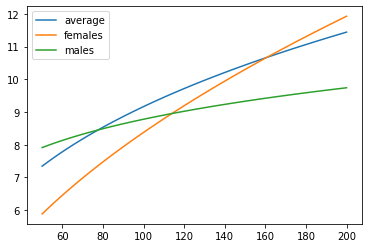

In [31]:
# https://onlinelibrary.wiley.com/doi/10.1002/mrm.24984
# Noninvasive MRI measurement of the absolute cerebral blood volume–cerebral blood flow relationship during visual stimulation in healthy humans
# Figure 4 shows curves of female and male CBF to CBV relation for each gender and for 9 ROIs.
# The curves vary a lot but the Smoker paper uses the average equation CBV = 2.1 *CBF^0.32 for everyone and everywhere
CBF = np.linspace(50,200,50)
plt.plot(CBF, 2.1 * pow(CBF,0.32),label='average')
plt.plot(CBF, 0.8 * pow(CBF,0.51),label='females')
plt.plot(CBF, 4.4 * pow(CBF,0.15),label='males')
plt.legend()
plt.show()
# https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.10257?sid=nlm%3Apubmed
# Cerebral venous and arterial blood volumes can be estimated separately in humans using magnetic resonance imaging
# DBV = 0.77 * CBV 
# not sure how trustworthy that 0.77 is. the images are very blurry and its a whole brain average.
# alpha = DBV/CBV=0.77 is used a lot in the QSM equation 
